## Chapter 21 - Dichotomous Predicted Variable

- [21.1 - Multiple Metric Predictors](#21.1---Multiple-Metric-Predictors)
- [21.3 - Robust Logistic Regression](#21.3---Robust-Logistic-Regression)
- [21.4 - Nominal Predictors](#21.4---Nominal-Predictors)

In [1]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from scipy.stats import beta
from scipy.special import expit
from matplotlib import gridspec
from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':16}

In [2]:
%load_ext watermark
%watermark -p pandas,numpy,pymc3,theano,matplotlib,seaborn,scipy

pandas 0.23.4
numpy 1.15.1
pymc3 3.5
theano 1.0.2
matplotlib 2.2.3
seaborn 0.9.0
scipy 1.1.0


In [3]:
def plot_mustache(o, k, j, width=.65, ax=None):
    for i in np.arange(0, len(o), int(len(o)*.1)):
        a = o[i]*(k[i]-2)+1
        b = (1-o[i])*(k[i]-2)+1
        rv = beta(a,b)
                
        yrange = np.linspace(rv.ppf(0.025), rv.ppf(0.975), 100)
        xrange = rv.pdf(yrange)
        
        # When the SD of a group is large compared to others, then the top of its mustache is relatively
        # low and does not plot well together with low SD groups.
        # Scale the xrange so that the 'height' of the all mustaches is 0.75
        xrange_scaled = xrange*(width/xrange.max())
        
        # Using the negative value to flip the mustache in the right direction.
        ax.plot(-xrange_scaled+j, yrange, color=color, alpha=.5)

### 21.1 - Multiple Metric Predictors

#### Data

In [4]:
df = pd.read_csv('data/HtWtData110.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 3 columns):
male      110 non-null int64
height    110 non-null float64
weight    110 non-null float64
dtypes: float64(2), int64(1)
memory usage: 2.7 KB


In [5]:
X = df[['height', 'weight']]
y = df['male']

meanx = X.mean().values
scalex = X.std().values
zX = ((X-meanx)/scalex).values

#### Model (Kruschke, 2015)

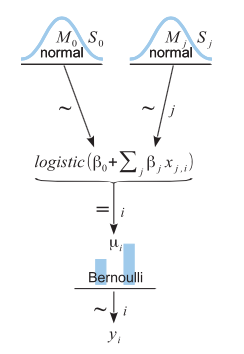

In [6]:
Image('images/fig21_2.png')

#### Predicting gender from weight alone

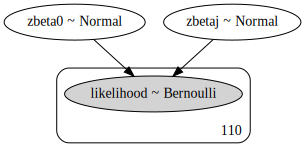

In [7]:
with pm.Model() as model_weight:
    
    zbeta0 = pm.Normal('zbeta0', mu=0, sd=2)
    zbetaj = pm.Normal('zbetaj', mu=0, sd=2)
        
    p = pm.invlogit(zbeta0 + zbetaj*zX[:,1])
        
    likelihood = pm.Bernoulli('likelihood', p, observed=y.values)

pm.model_to_graphviz(model_weight)

In [8]:
with model_weight:
    trace1 = pm.sample(3000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zbetaj, zbeta0]
Sampling 4 chains: 100%|██████████| 14000/14000 [00:03<00:00, 4528.64draws/s]


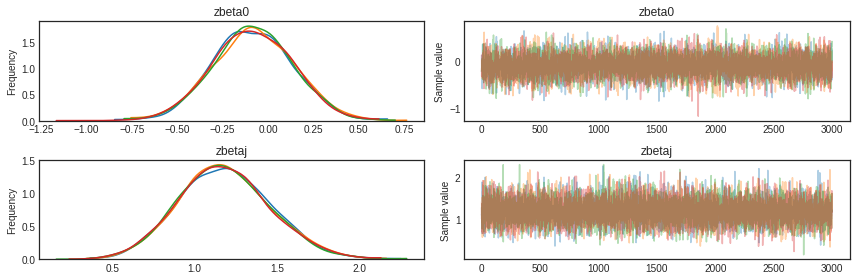

In [9]:
pm.traceplot(trace1);

#### Figure 21.3

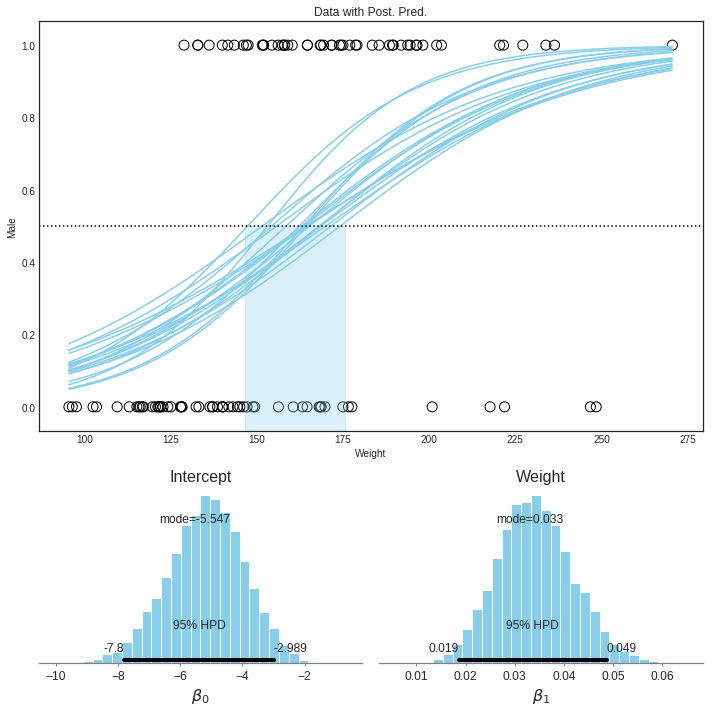

In [10]:
# Transform parameters back to original scale
beta0 = trace1['zbeta0'] - trace1['zbetaj']*meanx[1]/scalex[1]
betaj = (trace1['zbetaj']/scalex[1])

plt.figure(figsize=(10,10))
# Define gridspec
gs = gridspec.GridSpec(3, 4)
ax1 = plt.subplot(gs[:2,:4])
ax2 = plt.subplot(gs[2,:2])
ax3 = plt.subplot(gs[2,2:])

ax1.scatter(df.weight, df.male, s=100, edgecolor='k', facecolors='None', lw=1)

# Take 20 values from the posterior distribution and plot the lines
n_curves = 20
tr_len = len(trace1)
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves)
weight_span = np.arange(df.weight.min(), df.weight.max())
weights = np.tile(weight_span.reshape(-1,1), (1,n_curves))
# The expit function from scipy.special calculates the inverse of the logit function
p = expit(beta0[stepIdxVec] + betaj[stepIdxVec]*weights)
ax1.plot(weights, p, c=color)

ax1.axhline(y=0.5, color='k', linestyle='dotted')

# Look up weights for which of the posterior probabilities is (close to) 0.5
decision_boundary = weight_span[np.any(np.isclose(p, 0.5, atol=0.01), axis=1)]
# Highlight the weightspan
ax1.axvspan(decision_boundary.min(), decision_boundary.max(),
            0, 0.5, color=color, alpha=0.3)

ax1.set_xlabel('Weight')
ax1.set_ylabel('Male')
ax1.set_title('Data with Post. Pred.')

pm.plot_posterior(beta0, point_estimate='mode', ax=ax2, color=color)
ax2.set_title('Intercept', fontdict=f_dict)
ax2.set_xlabel(r'$\beta_0$', fontdict=f_dict)

pm.plot_posterior(betaj, point_estimate='mode', ax=ax3, color=color)
ax3.set_title('Weight', fontdict=f_dict)
ax3.set_xlabel(r'$\beta_1$', fontdict=f_dict);

plt.tight_layout();

#### Predicting gender from weight and height

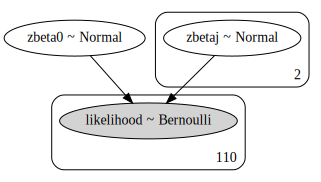

In [11]:
with pm.Model() as model:
    
    zbeta0 = pm.Normal('zbeta0', mu=0, sd=2)
    zbetaj = pm.Normal('zbetaj', mu=0, sd=2, shape=(2))
        
    p = pm.invlogit(zbeta0 + pm.math.dot(zbetaj, zX.T))
        
    likelihood = pm.Bernoulli('likelihood', p, observed=y.values)
    
pm.model_to_graphviz(model)

In [12]:
with model:
    trace2 = pm.sample(3000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zbetaj, zbeta0]
Sampling 4 chains: 100%|██████████| 14000/14000 [00:03<00:00, 3863.88draws/s]


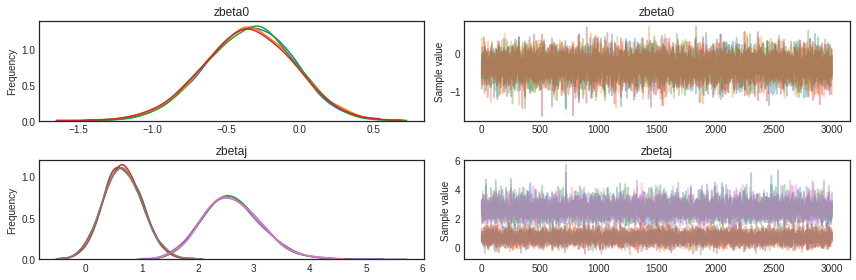

In [13]:
pm.traceplot(trace2);

#### Figure 21.4

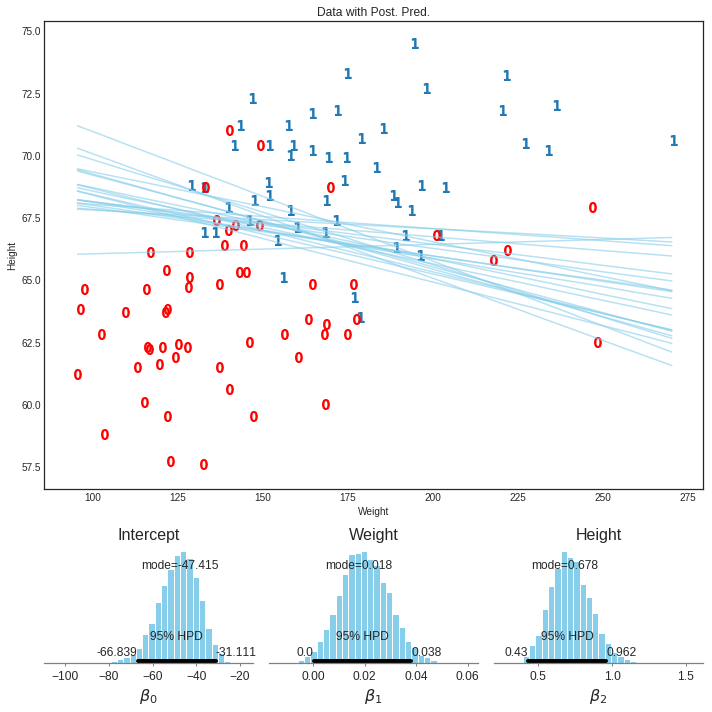

In [14]:
# Transform parameters back to original scale
beta0 = trace2['zbeta0'] - np.sum(trace2['zbetaj']*meanx/scalex, axis=1)
betaj = (trace2['zbetaj']/scalex)

plt.figure(figsize=(10,10))

# Define gridspec
gs = gridspec.GridSpec(4, 3)
ax1 = plt.subplot(gs[:3,:3])
ax2 = plt.subplot(gs[3,0])
ax3 = plt.subplot(gs[3,1])
ax4 = plt.subplot(gs[3,2])

mask = df.male == 1
ax1.scatter(df[mask].weight, df[mask].height, s=100, marker='$1$',)
ax1.scatter(df[~mask].weight, df[~mask].height, s=100, c='r', marker='$0$')
ax1.set_xlabel('Weight')
ax1.set_ylabel('Height')
ax1.set_title('Data with Post. Pred.')

# Take 20 values from the posterior distribution and plot the lines
tr_len = len(trace2)
n_curves = 20
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves)
weight_span = np.arange(df.weight.min(), df.weight.max())
height_span = np.arange(df.height.min(), df.height.max())

# Prepare grid for contour plot
xx, yy = np.meshgrid(height_span, weight_span, indexing='xy')
Z = np.zeros((weight_span.size,height_span.size))
# Calculate p based on grid of weights and heights
# ToDo: remove nested loop
for idx in stepIdxVec:
    for (i,j),v in np.ndenumerate(Z):
        Z[i,j] = expit(beta0[idx] + betaj[idx,0]*xx[i,j] + betaj[idx,1]*yy[i,j])
    CS = ax1.contour(yy, xx, Z, colors=color, alpha=0.6, levels=[0.5])

pm.plot_posterior(beta0, point_estimate='mode', ax=ax2, color=color)
ax2.set_title('Intercept', fontdict=f_dict)
ax2.set_xlabel(r'$\beta_0$', fontdict=f_dict)

pm.plot_posterior(betaj[:,1], point_estimate='mode', ax=ax3, color=color)
ax3.set_title('Weight', fontdict=f_dict)
ax3.set_xlabel(r'$\beta_1$', fontdict=f_dict)

pm.plot_posterior(betaj[:,0], point_estimate='mode', ax=ax4, color=color)
ax4.set_title('Height', fontdict=f_dict)
ax4.set_xlabel(r'$\beta_2$', fontdict=f_dict);

plt.tight_layout();

### 21.3 - Robust Logistic Regression

#### Predicting gender from weight alone (robust)

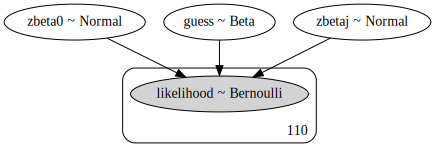

In [15]:
with pm.Model() as model_weight_robust:
    
    zbeta0 = pm.Normal('zbeta0', mu=0, sd=2)
    zbetaj = pm.Normal('zbetaj', mu=0, sd=2)
    
    guess = pm.Beta('guess', alpha=1, beta=9)
    
    p = (guess*(1/2) + (1.0-guess)*pm.invlogit(zbeta0 + zbetaj*zX[:,1]))
        
    likelihood = pm.Bernoulli('likelihood', p, observed=y.values)
    
pm.model_to_graphviz(model_weight_robust)

In [16]:
with model_weight_robust:
    trace3 = pm.sample(3000, cores=4, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [guess, zbetaj, zbeta0]
Sampling 4 chains: 100%|██████████| 14000/14000 [00:05<00:00, 2560.69draws/s]


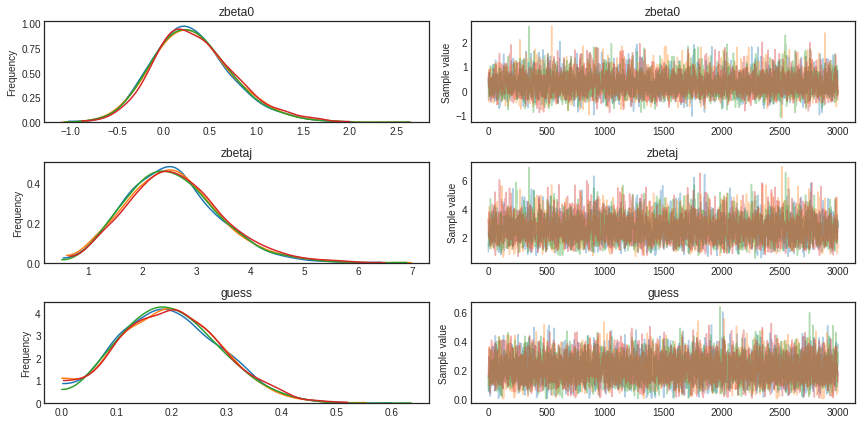

In [17]:
pm.traceplot(trace3);

#### Figure 21.8

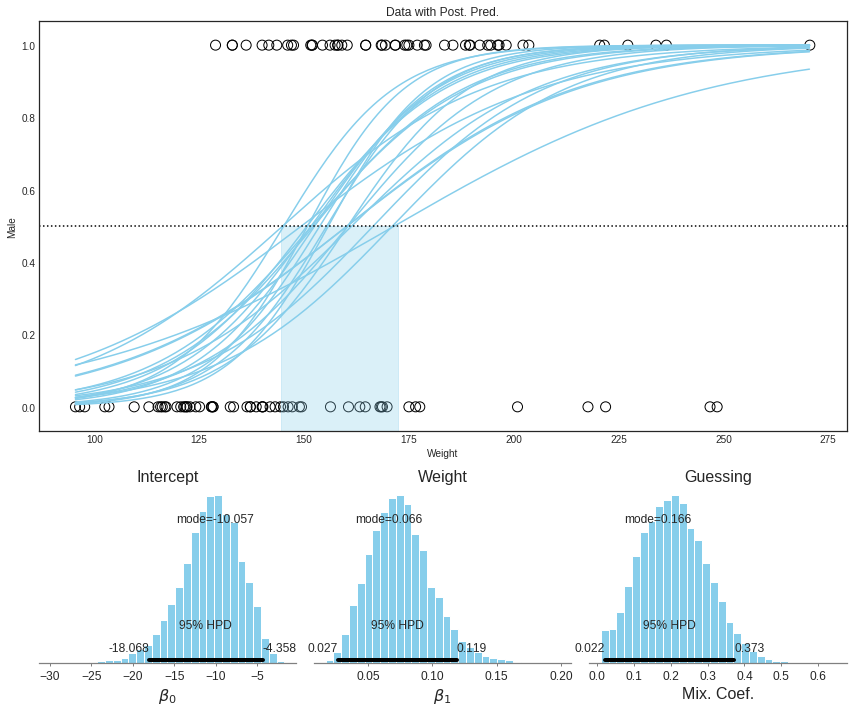

In [18]:
# Transform parameters back to original scale
beta0 = trace3['zbeta0'] - trace3['zbetaj']*meanx[1]/scalex[1]
betaj = (trace3['zbetaj']/scalex[1])

plt.figure(figsize=(12,10))
# Define gridspec
gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[:2,:3])
ax2 = plt.subplot(gs[2,0])
ax3 = plt.subplot(gs[2,1])
ax4 = plt.subplot(gs[2,2])

ax1.scatter(df.weight, df.male, s=100, edgecolor='k', facecolors='None', lw=1)

# Take 20 values from the posterior distribution and plot the lines
n_curves = 20
tr_len = len(trace3)
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves)
weight_span = np.arange(df.weight.min(), df.weight.max())
weights = np.tile(weight_span.reshape(-1,1), (1,n_curves))
# The expit function from scipy.special calculates the inverse of the logit function
p = expit(beta0[stepIdxVec] + betaj[stepIdxVec]*weights)
ax1.plot(weights, p, c=color)

ax1.axhline(y=0.5, color='k', linestyle='dotted')

# Look up weights for which of the posterior probabilities is (close to) 0.5
decision_boundary = weight_span[np.any(np.isclose(p, 0.5, atol=0.01), axis=1)]
# Highlight the weightspan
ax1.axvspan(decision_boundary.min(), decision_boundary.max(),
            0, 0.5, color=color, alpha=0.3)

ax1.set_xlabel('Weight')
ax1.set_ylabel('Male')
ax1.set_title('Data with Post. Pred.')

pm.plot_posterior(beta0, point_estimate='mode', ax=ax2, color=color)
ax2.set_title('Intercept', fontdict=f_dict)
ax2.set_xlabel(r'$\beta_0$', fontdict=f_dict)

pm.plot_posterior(betaj, point_estimate='mode', ax=ax3, color=color)
ax3.set_title('Weight', fontdict=f_dict)
ax3.set_xlabel(r'$\beta_1$', fontdict=f_dict);

pm.plot_posterior(trace3['guess'], point_estimate='mode', ax=ax4, color=color)
ax4.set_title('Guessing', fontdict=f_dict)
ax4.set_xlabel('Mix. Coef.', fontdict=f_dict);

plt.tight_layout();

### 21.4 - Nominal Predictors
#### 21.4.2 - Multiple groups

#### Data 
See also section 9.5.1

In [19]:
df2 = pd.read_csv('data/BattingAverage.csv', usecols=[0,1,2,3], dtype={'PriPos':'category'})
df2['BatAv'] = df2.Hits.divide(df2.AtBats)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 5 columns):
Player    948 non-null object
PriPos    948 non-null category
Hits      948 non-null int64
AtBats    948 non-null int64
BatAv     948 non-null float64
dtypes: category(1), float64(1), int64(2), object(1)
memory usage: 31.0+ KB


In [20]:
df2.head()

,Player,PriPos,Hits,AtBats,BatAv
0,Fernando Abad,Pitcher,1,7,0.142857
1,Bobby Abreu,Left Field,53,219,0.242009
2,Tony Abreu,2nd Base,18,70,0.257143
3,Dustin Ackley,2nd Base,137,607,0.225700
4,Matt Adams,1st Base,21,86,0.244186


#### Model (Kruschke, 2015)

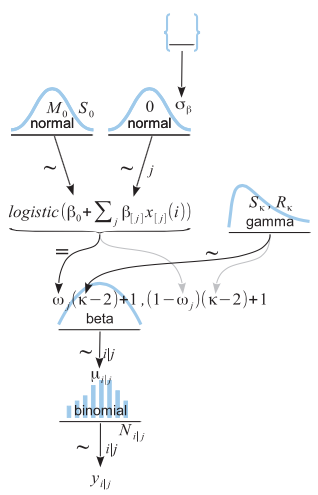

In [21]:
Image('images/fig21_12.png')

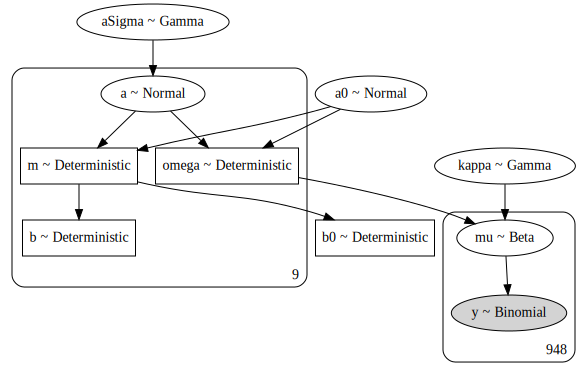

In [22]:
# Index of positions
pripos_idx = df2.PriPos.cat.codes.values
# The 9 position names
pripos_codes = df2.PriPos.cat.categories.values

n_pripos = pripos_codes.size
n_players = df2.Player.nunique()

with pm.Model() as hierarchical_model:
    # Hyper parameters
    aSigma = pm.Gamma('aSigma', 1.64, 0.32)
    a0 = pm.Normal('a0', 0.0, tau=1/2**2)
    a = pm.Normal('a', 0.0, tau=1/aSigma**2, shape=n_pripos) 
    
    # Parameters for categories (Primary field positions)
    omega = pm.Deterministic('omega', pm.invlogit(a0 + a))
    kappa = pm.Gamma('kappa', 0.01, 0.01)
    
    # Parameter for individual players
    mu = pm.Beta('mu',
                  omega[pripos_idx]*kappa+1, (1-omega[pripos_idx])*kappa+1,
                  shape = n_players)
    
    y = pm.Binomial('y', n=df2.AtBats.values, p=mu, observed=df2.Hits.values)
    
    # Convert a0,a to sum-to-zero b0,b 
    m = pm.Deterministic('m', a0 + a)
    b0 = pm.Deterministic('b0', tt.mean(m))
    b = pm.Deterministic('b', m - b0) 
    
pm.model_to_graphviz(hierarchical_model)

In [23]:
with hierarchical_model:
    trace4 = pm.sample(3000, cores=4, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, kappa, a, a0, aSigma]
Sampling 4 chains: 100%|██████████| 14000/14000 [04:11<00:00, 15.39draws/s]
The number of effective samples is smaller than 10% for some parameters.


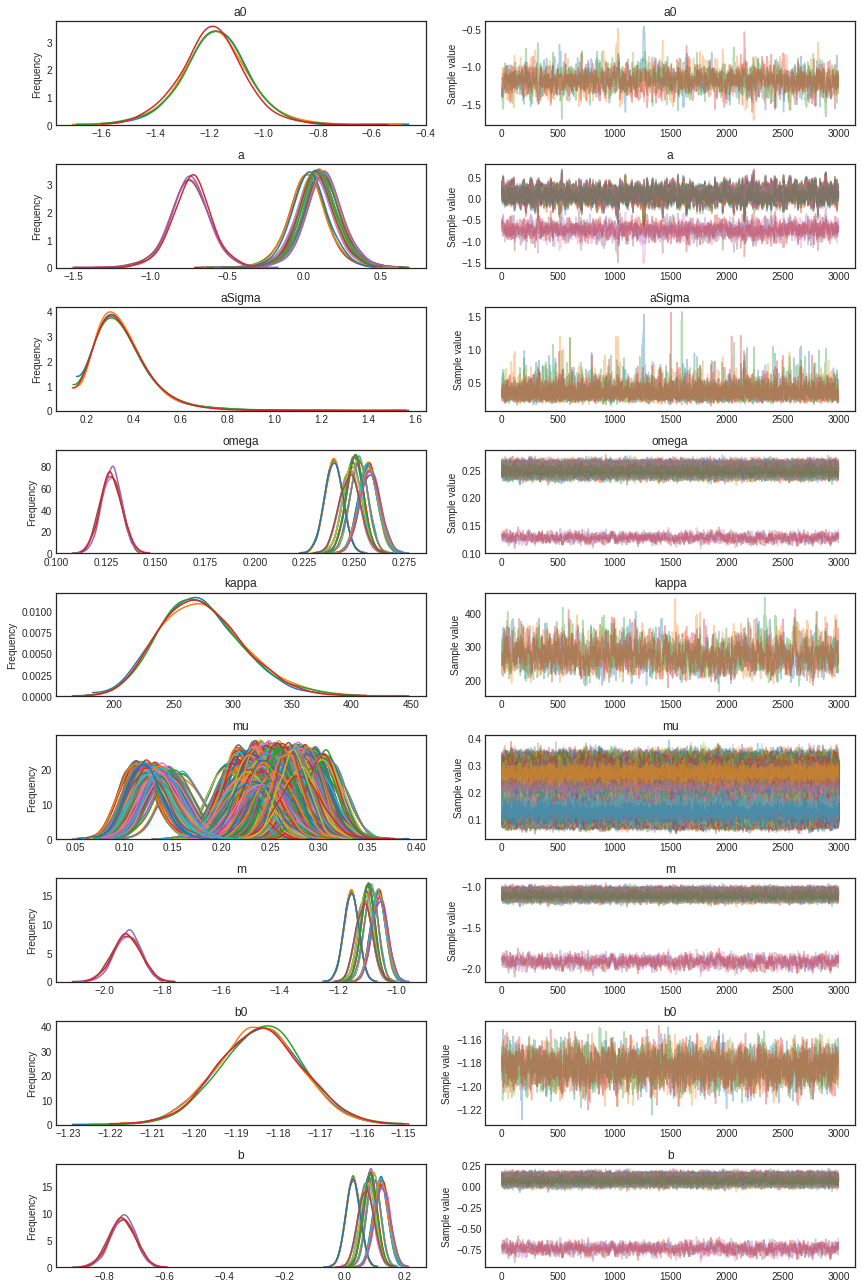

In [24]:
pm.traceplot(trace4);

#### Figure 21.13
Instead of plotting different dot sizes to represent `AtBat`, we can use a gradient color scale. With help of the pandas `cut()` function we can assign the `AtBat` values to 5 bins and use these values with the `hue` parameter of the seaborn `stripplot` function.

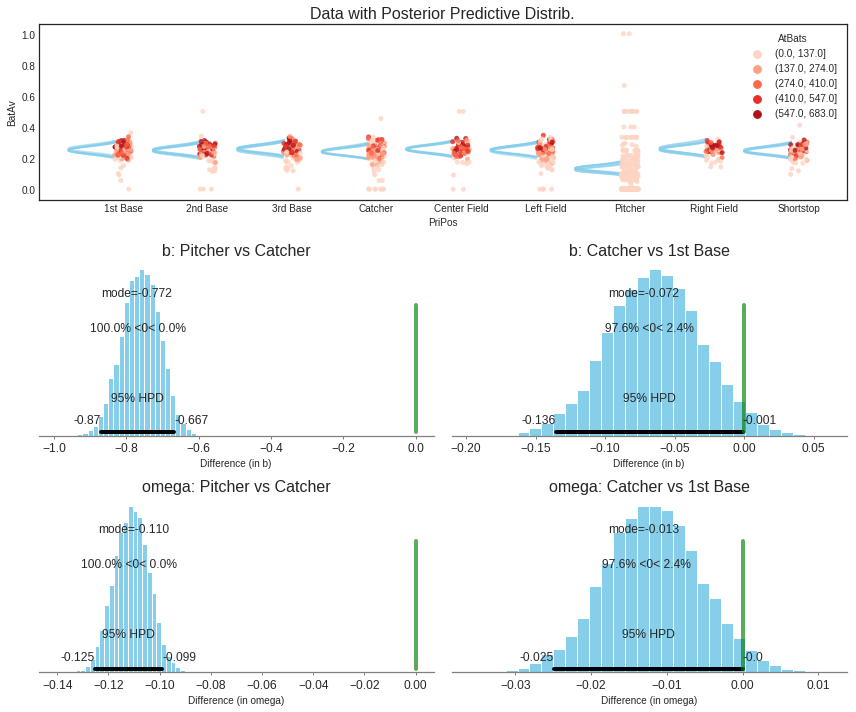

In [25]:
plt.figure(figsize=(12,10))
# Define gridspec
gs = gridspec.GridSpec(3, 2)
ax1 = plt.subplot(gs[0,:])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[1,1])
ax4 = plt.subplot(gs[2,0])
ax5 = plt.subplot(gs[2,1])

sns.stripplot(x='PriPos', y='BatAv', hue=pd.cut(df2.AtBats, 5, precision=0),
              data=df2, jitter=True, palette='Reds', ax=ax1, alpha=.8);

for pripos in np.arange(n_pripos):
    plot_mustache(trace4['omega'][:,pripos], trace4['kappa'], pripos, ax=ax1)
ax1.set_xlim(xmin=-1)
ax1.set_title('Data with Posterior Predictive Distrib.', fontdict=f_dict)
    
pm.plot_posterior(trace4['b'][:,6]-trace4['b'][:,3],
                   ref_val=0, ax=ax2, point_estimate='mode', color=color)
ax2.set_title('b: Pitcher vs Catcher', fontdict=f_dict)
pm.plot_posterior(trace4['b'][:,3]-trace4['b'][:,0],
                   ref_val=0, ax=ax3, point_estimate='mode', color=color)
ax3.set_title('b: Catcher vs 1st Base', fontdict=f_dict)
for ax in [ax2, ax3]:
    ax.set_xlabel('Difference (in b)')

pm.plot_posterior(trace4['omega'][:,6]-trace4['omega'][:,3],
                   ref_val=0, ax=ax4, point_estimate='mode', color=color)
ax4.set_title('omega: Pitcher vs Catcher', fontdict=f_dict)
pm.plot_posterior(trace4['omega'][:,3]-trace4['omega'][:,0],
                   ref_val=0, ax=ax5, point_estimate='mode', color=color)
ax5.set_title('omega: Catcher vs 1st Base', fontdict=f_dict)
for ax in [ax4, ax5]:
    ax.set_xlabel('Difference (in omega)')

plt.tight_layout();